<a href="https://colab.research.google.com/github/pedro21900/fase_4_tech_challenge/blob/main/fase_4_tech_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tech Challenge Fase 4 🎓

### Sobre a base de dados 🎲

A base de dados do **yfinance** (Yahoo Finance) é uma API em Python que fornece acesso a uma ampla gama de informações financeiras do mercado. Ela permite obter dados históricos de preços de ações,fundos, modedas e criptomoedas, bem  como informações fundamentais e estatísticas de mercado, como:

<ol>
    <li><b>Preços históricos:</b> Abertura, fechamento, alta, baixa e volume negociado,com suporte para intevelos variados (dia,semana, mês) </li>
    <li><b>Dados fundamentais:<b/> Dividendos, splits de ações, balanços financeiros, lucros e métricas como P/E ratio.</li>
    <li><b>Dados em tempo real:</b> Preços de mercado atualizados (dependendo das limitações de atraso e região).</li>
    <li><b>Informações de mercado:</b> Volatilidade, beta, valor de mercado e outros indicadores.</li>
</ol>    

O yfinance pe amplamente ultilizado devido à facilidade de integração com pandas e à abrangência dos daos oferecidos, tornando-se uma ferramente insdispensável para análise quantitativa, estratégica de investimento e pesquisa financeira

Objetivo 🚀

Desenvolver um modelo preditivo ultilizando redes neurais LSTM (Long Short Term Memory) para predizer o valor de fechamento da bolsa de valores da **Disney**.

### Instalando Bibliotecas

In [1]:
!pip install mlflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install torch
!pip install seaborn

### Importando bibliotecas

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mlflow
import mlflow.pytorch
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score

### Baixando dataset do yfinance

Este techo de código configura o **yfinance** para baixar o histórico de 01/01/2018 a 20/07/2024 do ticket **'DIS' (Disney)**

In [75]:
# Baixar os dados históricos para o ticker PETR4
df = yf.download('DIS')
len(df)

[*********************100%***********************]  1 of 1 completed


15836

### Análise dos dados

Neste trecho, plotamos o volume anual, onde é possível observar que, em 2021, houve um aumento significativamente fora do padrão, podendo ser considerado um outlier.

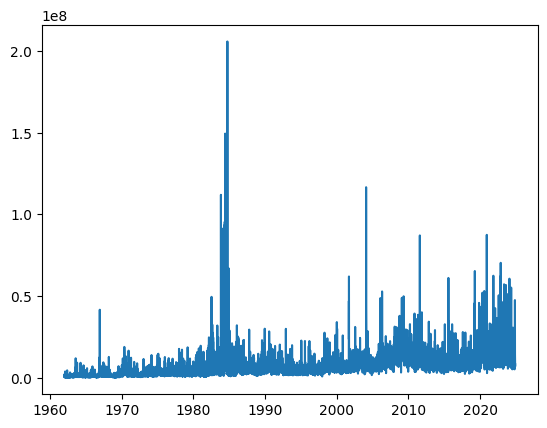

In [76]:
timeseries = df[["Volume"]].values.astype('float32')

plt.plot(df.index, timeseries)
plt.show()

Neste trecho, plotamos o heatmap para encontrar a combinação mais relevante dos dados em relação ao fechamento da bolsa de valores

<Axes: >

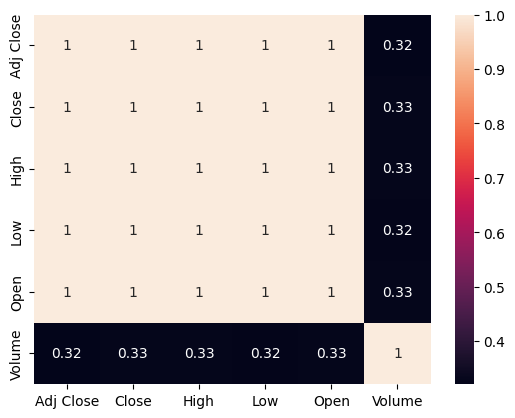

In [77]:
df.columns = ['_'.join(col).replace('_DIS', '').strip() if isinstance(col, tuple) else col for col in df.columns]
sns.heatmap( df.corr(), annot = True)


### Construindo o modelo

In [78]:
def remove_outliers(dataframe: DataFrame, columns: list):
    """Remove outliers de colunas específicas do DataFrame."""

    for col in columns:
        # Obtém os valores da coluna como um array
        data = dataframe[col].values

        # Calcula o primeiro e terceiro quartil, e o intervalo interquartílico
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1

        # Calcula os limites inferior e superior
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Substitui os valores fora dos limites por NaN
        dataframe.loc[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound), col] = np.nan

    # Remove as linhas que contêm NaN em qualquer coluna
    df.dropna(how='any', inplace=True)
    return dataframe

In [79]:

df =  df.reset_index()
df = df.drop(columns=['Date'])
#df = remove_outliers(df, df.columns)
#df.interpolate(method='linear', inplace=True)

X = df.drop(columns=['Close']).values.astype(np.float32)
Y = df[['Close']].values.astype(np.float32)

scalerX = StandardScaler()
scalerY = StandardScaler()
X = scalerX.fit_transform(X)
Y = scalerY.fit_transform(Y)

#### Hiperparâmetros

Após algumas tentativas verificamos que essa é a mlehor combinação de hiperparâmetos do modelo

In [80]:
input_size = 5
hidden_size = 100
num_layers = 4
output_size = 1
learning_rate = 0.01
num_epochs = 10
batch_size = 64

#### Criando o modelo lstm

In [81]:
# Modelo LSTM com arquitetura sequencial
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        # Passa os dados pelo modelo sequencial
        output, _ = self.lstm(x)

        return self.fc(output)

#### Convertendo o dataframe para um dataset

In [82]:
# Dataset para treinamento
class YfinanceTrainDataset(Dataset):
    def __init__(self, x, y):
        super(YfinanceTrainDataset, self).__init__()

        self.data = x
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

#### Configurando treinamento do modelo

In [83]:
# Dispositivo (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Funções de treinamento e avaliação
def train_model(train_loader, test_loader):
    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    mlflow.set_experiment("LSTM Artificial Data Regression")
    with mlflow.start_run():
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("output_size", output_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for i, (sequences, labels) in enumerate(train_loader):
                sequences, labels = sequences.to(device), labels.to(device)

                # Forward pass
                outputs = model(sequences)
                loss = criterion(outputs, labels)

                # Backward pass e otimização
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if i % 100 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
                    mlflow.log_metric("train_loss", running_loss / (i+1), step=epoch * len(train_loader) + i)

        mlflow.pytorch.log_model(model, "lstm_artificial_data_model")
        evaluate_model(model, test_loader)
        return model


def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = nn.MSELoss()(outputs, labels)
            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {average_test_loss:.4f}")
    mlflow.log_metric("test_loss", average_test_loss)

In [84]:
dataset = YfinanceTrainDataset(X, Y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = train_model(train_loader, test_loader)

Epoch [1/10], Step [1/248], Loss: 1.1408
Epoch [1/10], Step [101/248], Loss: 0.0173
Epoch [1/10], Step [201/248], Loss: 0.0073
Epoch [2/10], Step [1/248], Loss: 0.0021
Epoch [2/10], Step [101/248], Loss: 0.0006
Epoch [2/10], Step [201/248], Loss: 0.0006
Epoch [3/10], Step [1/248], Loss: 0.0008
Epoch [3/10], Step [101/248], Loss: 0.0020
Epoch [3/10], Step [201/248], Loss: 0.0010
Epoch [4/10], Step [1/248], Loss: 0.0015
Epoch [4/10], Step [101/248], Loss: 0.0051
Epoch [4/10], Step [201/248], Loss: 0.0010
Epoch [5/10], Step [1/248], Loss: 0.0013
Epoch [5/10], Step [101/248], Loss: 0.0048
Epoch [5/10], Step [201/248], Loss: 0.0038
Epoch [6/10], Step [1/248], Loss: 0.0058
Epoch [6/10], Step [101/248], Loss: 0.0033
Epoch [6/10], Step [201/248], Loss: 0.0007
Epoch [7/10], Step [1/248], Loss: 0.0010
Epoch [7/10], Step [101/248], Loss: 0.0007
Epoch [7/10], Step [201/248], Loss: 0.0028
Epoch [8/10], Step [1/248], Loss: 0.0025
Epoch [8/10], Step [101/248], Loss: 0.0024
Epoch [8/10], Step [201/248

2024/11/29 03:17:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/29 03:17:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/29 03:17:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Loss: 0.0027


### Testanto modelo

In [85]:
# Exemplo de entrada
entrada = np.array([[107.875183,		111.809998,	108.559998,	108.949997,	11014300]], dtype=np.float32)

# Transformação dos dados
entrada_normalizada = scalerX.transform(entrada)

# Converte para tensor e ajusta para o formato esperado pelo modelo (batch_size=1, seq_len=1, input_size=4)
entrada_tensor = torch.tensor(entrada_normalizada, dtype=torch.float32).unsqueeze(0).to(device)

# Obtenha o resultado do modelo
result = model(entrada_tensor)  # Certifique-se de que model é uma função ou objeto chamável

# Desconecte o tensor do grafo computacional e converta para NumPy
result_numpy = result.detach().cpu().numpy()  # Use `.cpu()` se o tensor estiver na GPU

# Desnormalização
result_desnormalizado = scalerY.inverse_transform(result_numpy[0])

print(result_desnormalizado)


[[109.90209]]
